# Simple analysis example of HWP using SO HK data 
SO HK data reading and writing tips: <br>
https://so3g.readthedocs.io/en/latest/hk.html#writing-hk-data

## `update_hwp_angle`
package to provide HWP angle and approximated speed from SO HK data <br>
https://docs.google.com/document/d/1Hb0LMDB7oUXugeHKqMLOq8EvVijHvPN7ZgB4yZgIEaU/edit?usp=sharing <br>

## Run as script

In [1]:
!python update_hwp_angle.py -h

usage: update_hwp_angle.py [-h] -f [FILE [FILE ...]] [--output OUTPUT]

Analyze HWP encoder data from level-2 HK data, and produce HWP angle solution
for all times.

optional arguments:
  -h, --help            show this help message and exit
  -f [FILE [FILE ...]], --file [FILE [FILE ...]]
                        A filename or list of filenames (to be loaded in
                        order).
  --output OUTPUT       A path to output g3 file


In [2]:
!python update_hwp_angle.py --file /mnt/SOdata/pton-tsat/hk/16395/1639599416.g3

files=['/mnt/SOdata/pton-tsat/hk/16395/1639599416.g3']
output=./output.g3


## Import libraries
Import SO related libraries: so3g, update_hwp_angle <br>
If you see any error after this, check the name of kernel. 

In [206]:
import sys
import os
import numpy as np
import datetime as dt
import time as tm
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import glob

from update_hwp_angle import update_hwp_angle
import hwp
import so3g
from sotodlib import core, flags, tod_ops, sim_flags
from sotodlib.io.load_smurf import load_file
from sotodlib.tod_ops import fourier_filter, rfft, detrend_tod
import sotodlib.tod_ops.filters as filters

### Load SO HK data with time range

In [207]:
start, end = 1643340368.424739, 1643340969.269591 #spinup data from TSAT (Pton)
archive_path = '/mnt/so1/data/pton-tsat/hk/' # path to HK data archive
hwp_angle_tool = update_hwp_angle()
data_spinup = hwp_angle_tool.load_data(start, end, archive_path)

In [208]:
start, end = 1643342329, 1643342929 # 2Hz rotation data from TSAT (Pton)
archive_path = '/mnt/so1/data/pton-tsat/hk/' # path to HK data archive
hwp_angle_tool = update_hwp_angle()
data_rot = hwp_angle_tool.load_data(start, end, archive_path)

### Analyze loaded HWP parameters and return angles
Return  dict{fast_time, angle, slow_time, stable, locked, hwp_rate}
* fast_time: IRIG synched timing (~2kHz) 
* angle (float): IRIG synched HWP angle in radian
* slow_time: time list of slow block
* stable (flag): if non-zero, indicates the HWP spin state is known. i.e. it is either spinning at a measurable rate, or stationary.  When this flag is non-zero, the hwp_rate field can be taken at face value.
* locked (flag): if non-zero, indicates the HWP is spinning and the position solution is working. 
* hwp_rate (float): the "approximate" HWP spin rate, with sign, in revs / second.  Use placeholder value of 0 for cases when not "stable".

In [209]:
solved_spinup = hwp_angle_tool.analyze(data_spinup)

In [210]:
solved_rot = hwp_angle_tool.analyze(data_rot)

### Load SO HK data with g3 file name 

In [211]:
tsat_g3 = '/mnt/SOdata/pton-tsat/hk/16395/1639599416.g3'

In [212]:
hwp_angle_tool = update_hwp_angle()
data_file = hwp_angle_tool.load_file(tsat_g3)
solved_file = hwp_angle_tool.analyze(data_file)

In [213]:
print(solved_file['hwp_rate'][np.where(solved_file['locked'])])

[0.6580408  0.6580408  0.6580408  ... 0.76666377 0.76666377 0.76666377]


### Plot hwp speed & angle

In [214]:
def fit_hwp_speed(x,a,b,c,d):
       return a*np.exp(-b*x + c) + d

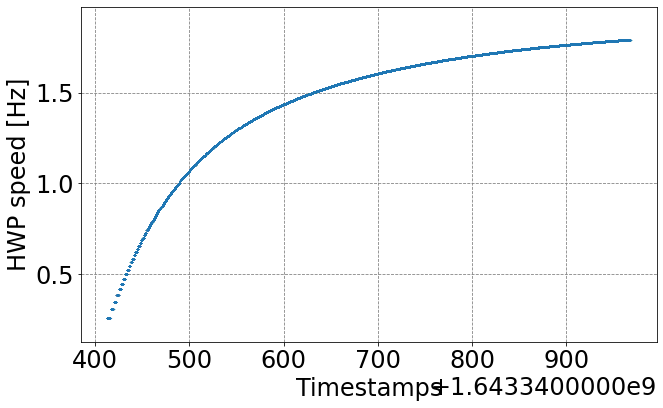

In [215]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_spinup['locked'])
plt.plot(solved_spinup['slow_time'][idx],solved_spinup['hwp_rate'][idx],'.', markersize=0.1)

plt.ylim(solved_spinup['hwp_rate'][idx].min()*0.5,solved_spinup['hwp_rate'][idx].max()*1.1)
plt.show()

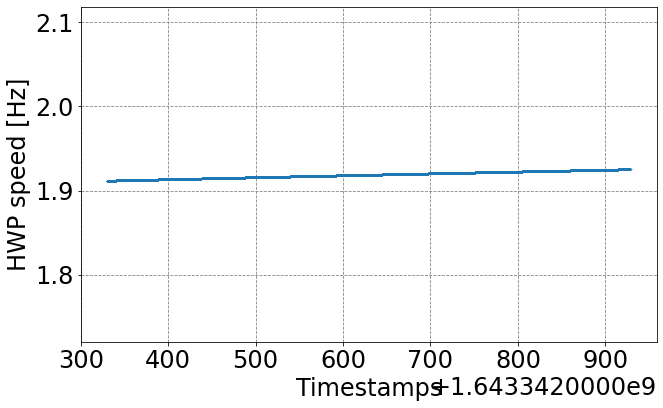

In [216]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['slow_time'][idx],solved_rot['hwp_rate'][idx],'.', markersize=0.1)
plt.ylim(solved_rot['hwp_rate'][idx].min()*0.9,solved_rot['hwp_rate'][idx].max()*1.1)
plt.show()

In [217]:
popt, pcov = sp.optimize.curve_fit(fit_hwp_speed, solved_rot['slow_time'][idx] - solved_rot['slow_time'][idx][0], solved_rot['hwp_rate'][idx],p0=[-1,1e-3,1,1])

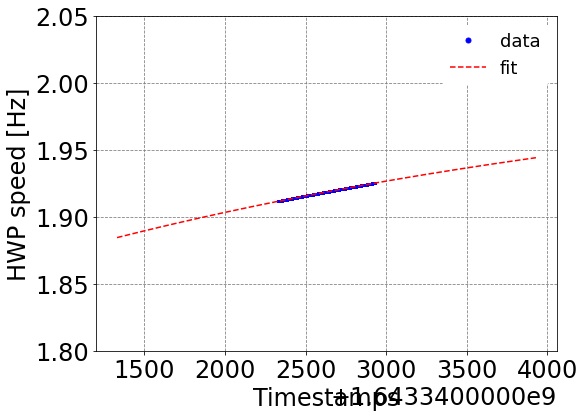

In [218]:
plt_time = np.arange(solved_rot['slow_time'][idx][0]-1000,solved_rot['slow_time'][idx][-1]+1000,0.1)
plt.figure(figsize=(8,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['slow_time'][idx],solved_rot['hwp_rate'][idx],'.b', markersize=1,label='data')
plt.plot(plt_time,fit_hwp_speed(plt_time - solved_rot['slow_time'][idx][0], *popt),'--r',label='fit')
plt.ylim(1.8,2.05)
plt.legend(markerscale=10)
plt.show()

In [173]:
print(solved_rot)

{'fast_time': array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'angle': array([0.65587636, 0.66138793, 0.66689949, ..., 1.67551608, 1.68102765,
       1.68653921]), 'slow_time': array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09]), 'stable': array([ True,  True,  True, ...,  True,  True,  True]), 'locked': array([False, False, False, ..., False, False, False]), 'hwp_rate': array([0., 0., 0., ..., 0., 0., 0.])}


In [174]:
np.argwhere(solved_rot['locked']).flatten()
(solved_rot['fast_time'])[idx]

array([1.64334233e+09, 1.64334233e+09, 1.64334233e+09, ...,
       1.64334293e+09, 1.64334293e+09, 1.64334293e+09])

In [175]:
idx = np.argwhere(solved_rot['locked']).flatten()
len(idx),len(solved_rot['fast_time'])

(1309860, 1312328)

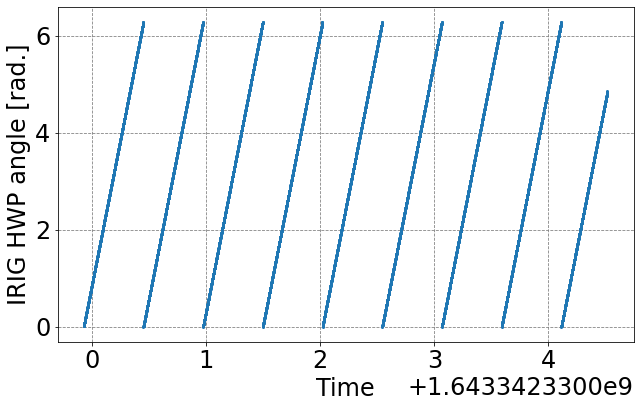

In [176]:
n = 10000
plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.argwhere(solved_rot['locked']).flatten()
plt.plot(solved_rot['fast_time'][idx][:n], solved_rot['angle'][idx][:n], '.',markersize=4)
plt.show()

### Output HWP angle g3 file with SO HK data format (optional)

In [177]:
hwp.write_solution(solved_rot,'output.g3')

### Laod output angle g3 file

In [178]:
scanner = so3g.hk.HKArchiveScanner()
filename = 'output.g3'
scanner.process_file(filename)
arc = scanner.finalize()
print(arc.get_data()[0].keys())

dict_keys(['hwp.hwp_rate', 'hwp.locked', 'hwp.stable', 'hwp.hwp_angle'])


In [179]:
fields = ['hwp.hwp_angle', 'hwp.locked', 'hwp.stable','hwp.hwp_rate']

In [180]:
output_data = arc.simple(fields)
fast_time = output_data[0][0]
angle = output_data[0][1]
slow_time = output_data[1][0]
locked = output_data[1][1]
stable = output_data[2][1]
hwp_rate = output_data[3][1]

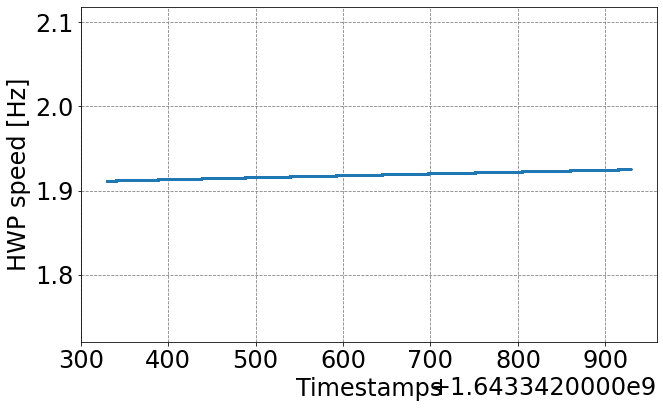

In [181]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('HWP speed [Hz]')
idx = np.where(solved_rot['locked'])
plt.plot(slow_time[idx],hwp_rate[idx],'.',markersize=1)
plt.ylim(hwp_rate[idx].min()*0.9,hwp_rate[idx].max()*1.1)
plt.show()

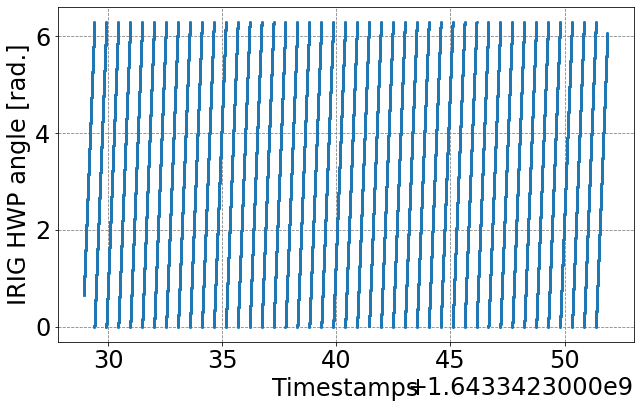

In [182]:
n = 50000
plt.figure(figsize=(10,6))
plt.xlabel('Timestamps')
plt.ylabel('IRIG HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(output_data[0][0][:n],output_data[0][1][:n],'.',markersize=4)
plt.show()

## Example of detector timestream + HWP analysis

### load timestream

**HWP spinning at around 2Hz** <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_000.g3 <br>
/pton-rd/timestreams/16433/crate1slot4/1643342329_001.g3

In [183]:
#archive_path = '/path/to/data/timestream/'
archive_path = '/mnt/so1/data/pton-rd/timestreams/16433/crate1slot4'
aman = load_file([   
    archive_path + '/1643342329_000.g3',
    archive_path + '/1643342329_001.g3',
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.08s/it]


In [184]:
phase_to_pA = 9e6/(2*np.pi) #design value of uMUX calculated from mutual inductance of TES and SQUID loop
aman.signal *= phase_to_pA

### Llinear interpolation between IRIG and SMuRF timing

In [185]:
import scipy
hwp_angle = scipy.interpolate.interp1d(solved_rot['fast_time'], solved_rot['angle'], kind='linear',fill_value='extrapolate')(aman.timestamps) % (2*np.pi)

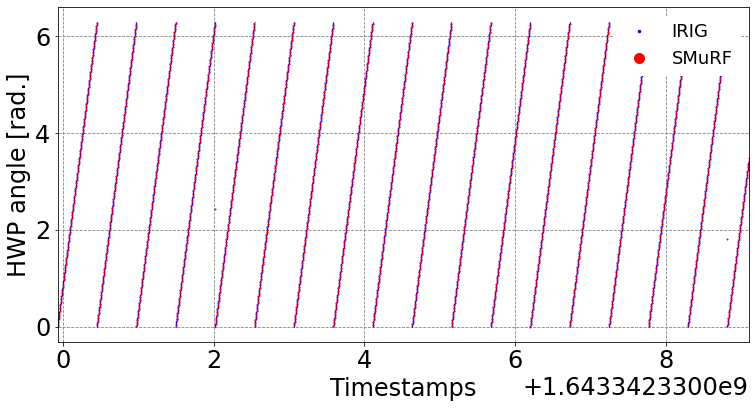

In [186]:
s = 0; e = 20000
plt.figure(figsize=(12,6), facecolor='w')
plt.xlabel('Timestamps')
plt.ylabel('HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['fast_time'][idx], solved_rot['angle'][idx], '.b',markersize=0.5, label='IRIG')
plt.plot(aman.timestamps, hwp_angle, '.r', markersize=2, label ='SMuRF')
plt.xlim(solved_rot['fast_time'][idx][s],solved_rot['fast_time'][idx][e])
#plt.ylim(0,5)
plt.legend(loc=0,markerscale=10)
plt.show()

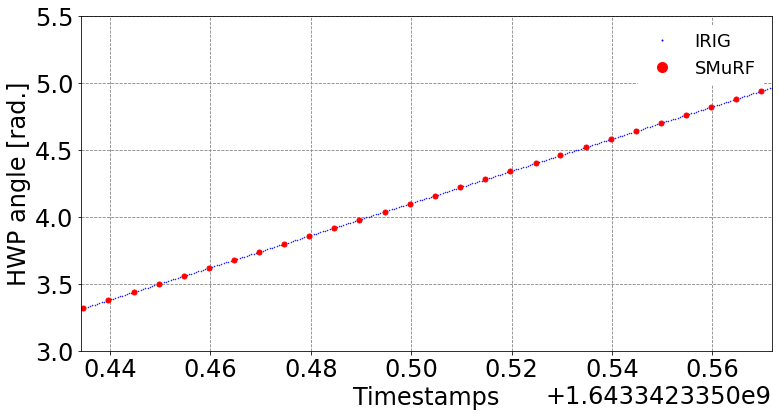

In [187]:
n = 12300
plt.figure(figsize=(12,6), facecolor='w')
plt.xlabel('Timestamps')
plt.ylabel('HWP angle [rad.]')
idx = np.where(solved_rot['locked'])
plt.plot(solved_rot['fast_time'][idx], solved_rot['angle'][idx], '.b',markersize=1, label='IRIG')
plt.plot(aman.timestamps, hwp_angle, '.r', markersize=10, label ='SMuRF')
plt.xlim(solved_rot['fast_time'][idx][12000],solved_rot['fast_time'][idx][n])
plt.ylim(3,5.5)
plt.legend(loc=0,markerscale=2)
plt.show()

# HWP Syncrhnous Signal Simulation and Subtraction

## HWPSS simulation

In [128]:
sampling_rate = 200 #Hz
obs_time = 6000 #s = 10min
n_ch = 10 # number of bolos.
dets_name = ['det' + str(i+1) for i in range(n_ch)] # detector name
aman_sim = core.AxisManager(core.LabelAxis('dets', dets_name), core.OffsetAxis('samps', obs_time*sampling_rate),) # AxisManager

### White noise

In [129]:
rng = np.random.default_rng()
if not 'timestamps' in aman_sim.keys(): aman_sim.wrap('timestamps', (1/sampling_rate)*np.arange(aman_sim.samps.count), [(0,'samps')] )
white_noise_level = 0.270 *np.sqrt(2) ## mK_RJ / rt. Hz for MF2 detectors
if not 'noise' in aman_sim.keys(): aman_sim.wrap('noise', rng.normal(scale=np.sqrt(white_noise_level**2*sampling_rate / 2), size=(aman_sim.dets.count, aman_sim.samps.count)), [(0,'dets'), (1,'samps')])

### 1/f noise

In [130]:
f_knee = 0.2 # Hz
alpha = -1.5
fs = np.median(np.diff(aman_sim.timestamps))
freqs = np.fft.fftfreq( aman_sim.samps.count, fs)
one_over_f = (white_noise_level*(np.abs(freqs) / f_knee)**alpha) * np.exp(1.0j*np.mod(np.random.uniform(2*np.pi, size=(aman_sim.dets.count, aman_sim.samps.count)), 1*np.pi))
one_over_f[:,0] = 0
one_over_f *= np.sqrt( fs * aman_sim.samps.count**2 / 2)
if not 'one_over_f' in aman_sim.keys(): aman_sim.wrap('one_over_f', np.real(np.fft.ifft( one_over_f )), [(0,'dets'), (1,'samps')])
else: aman_sim.one_over_f = np.real(np.fft.ifft( one_over_f ))

/tmp/ipykernel_4169/409377576.py:5: RuntimeWarning: divide by zero encountered in power
  one_over_f = (white_noise_level*(np.abs(freqs) / f_knee)**alpha) * np.exp(1.0j*np.mod(np.random.uniform(2*np.pi, size=(aman.dets.count, aman.samps.count)), 1*np.pi))


In [131]:
if not 'flags' in aman_sim.keys(): aman_sim.wrap('flags', core.FlagManager.for_tod(aman))
else: aman_sim.flags = core.FlagManager.for_tod(aman)

In [132]:
if not 'signal_one_over_f' in aman_sim.keys(): aman_sim.wrap('signal_one_over_f', aman_sim.noise+aman_sim.one_over_f, [(0,'dets'), (1,'samps')] )
else: aman_sim.signal_one_over_f = aman_sim.noise+aman_sim.one_over_f

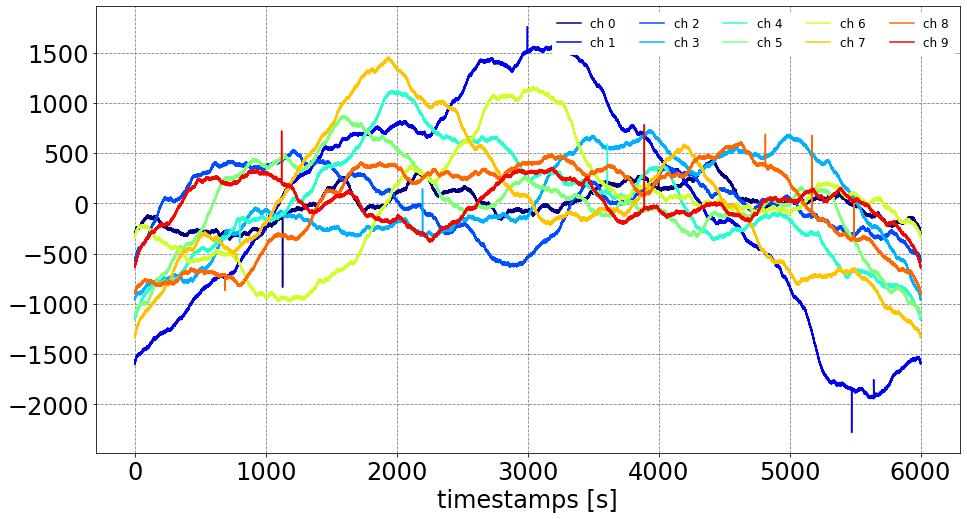

In [145]:
plt.figure(figsize=(15,8))
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_one_over_f[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(loc=1,ncol=5,fontsize=12)
plt.show()

## Glitches

In [143]:
if 'glitch_large' in aman_sim.keys(): aman_sim.glitch_large[:,None] = 0
if 'glitch_small' in aman_sim.keys(): aman_sim.glitch_small[:,None] = 0
sim_flags.add_random_glitches( aman, params={'n_glitches': 10, 'sig_n_glitch': 10, 'h_glitch':100, 'sig_h_glitch':300}, signal='glitch_large', overwrite=True)
sim_flags.add_random_glitches( aman, params={'n_glitches': 50, 'sig_n_glitch': 50, 'h_glitch':10, 'sig_h_glitch':5}, signal='glitch_small', overwrite=True)

In [144]:
if not 'signal_dets' in aman_sim.keys(): aman_sim.wrap('signal_dets', aman_sim.noise + aman_sim.glitch_large + aman_sim.glitch_small, [(0,'dets'), (1,'samps')] )
else: aman_sim.signal_dets = aman_sim.noise + aman_sim.glitch_large + aman_sim.glitch_small
aman_sim.signal_one_over_f = aman_sim.one_over_f + aman_sim.signal_dets

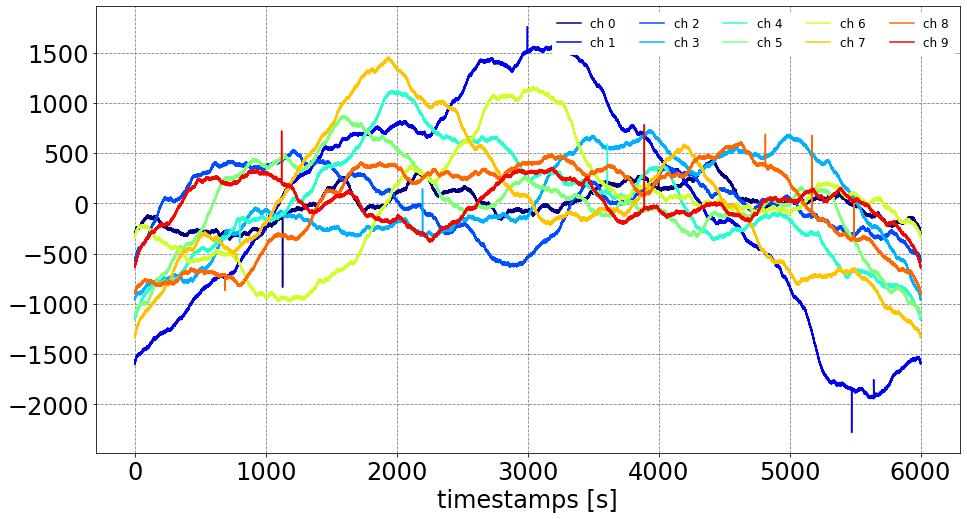

In [145]:
plt.figure(figsize=(15,8))
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_one_over_f[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(loc=1,ncol=5,fontsize=12)
plt.show()

## Save AxisManager

In [33]:
#aman_sim.save('tutorial_hwp.h5', 'aman')

## Load AxisManager

In [34]:
#aman = core.AxisManager.load('tutorial_hwp.h5', 'aman')

## Simulate HWPSS TOD

In [219]:
import importlib
import hwp
importlib.reload(hwp)
import hwp

In [147]:
hwp_freq = 2.0
hwp.sim_hwpss(aman, hwp_freq=hwp_freq)

In [148]:
if 'signal_hwpss' in aman_sim.keys(): aman_sim.move('signal_hwpss','')
aman_sim.wrap('signal_hwpss', aman_sim.signal_one_over_f+aman_sim.hwpss, [(0,'dets'), (1,'samps')] )

AxisManager(timestamps[samps], noise[dets,samps], one_over_f[dets,samps], flags*[dets,samps], signal_one_over_f[dets,samps], glitch_large[dets,samps], glitch_small[dets,samps], signal_dets[dets,samps], hwpss[dets,samps], hwp_angle[samps], signal_hwpss[dets,samps], dets:LabelAxis(10), samps:OffsetAxis(1200000))

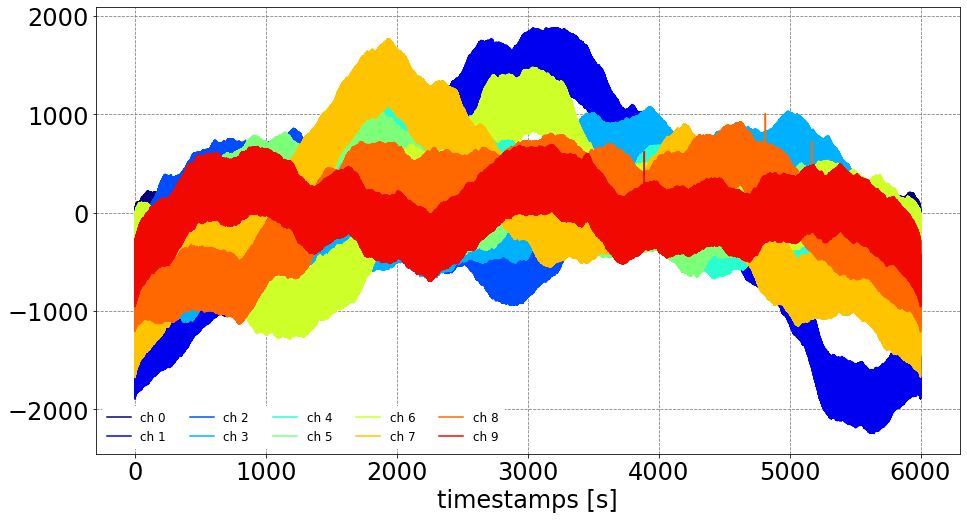

In [149]:
plt.figure(figsize=(15,8))
for i in range(aman_sim.dets.count): plt.plot(aman_sim.timestamps,aman_sim.signal_hwpss[i],color=cm.jet(i/aman_sim.dets.count),label='ch '+str(i))
plt.xlabel('timestamps [s]')
plt.legend(ncol=5,fontsize=12)
plt.show()

## Extract HWPSS from simulated TOD

In [150]:
hwp.ext_hwpss(aman,mode=0,signal='signal_hwpss')

In [151]:
if 'signal_sub_hwpss' in aman_sim.keys(): aman_sim.move('signal_sub_hwpss','')
aman_sim.wrap('signal_sub_hwpss', aman_sim.signal_hwpss-aman_sim.ext_hwpss, [(0,'dets'), (1,'samps')] )

AxisManager(timestamps[samps], noise[dets,samps], one_over_f[dets,samps], flags*[dets,samps], signal_one_over_f[dets,samps], glitch_large[dets,samps], glitch_small[dets,samps], signal_dets[dets,samps], hwpss[dets,samps], hwp_angle[samps], signal_hwpss[dets,samps], ext_hwpss[dets,samps], signal_sub_hwpss[dets,samps], dets:LabelAxis(10), samps:OffsetAxis(1200000))

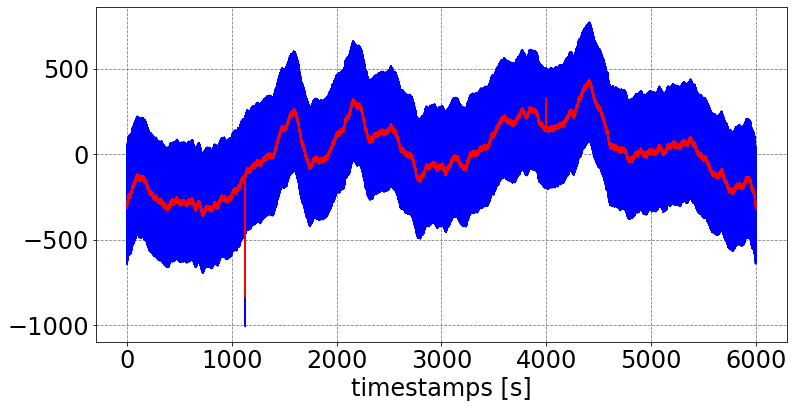

In [152]:
ch = 0
plt.figure(figsize=(12,6))
plt.plot(aman_sim.timestamps, aman_sim.signal_hwpss[ch],color='b')
plt.plot(aman_sim.timestamps, aman_sim.signal_sub_hwpss[ch],color='r')
plt.xlabel('timestamps [s]')
plt.show()

In [153]:
ffts_b, freqs_b = rfft(aman, resize=None, signal_name='signal_hwpss')
ffts_a, freqs_a = rfft(aman, resize=None, signal_name='signal_sub_hwpss')
tsamp = np.median(np.diff(aman_sim.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_sim.samps.count))**2)

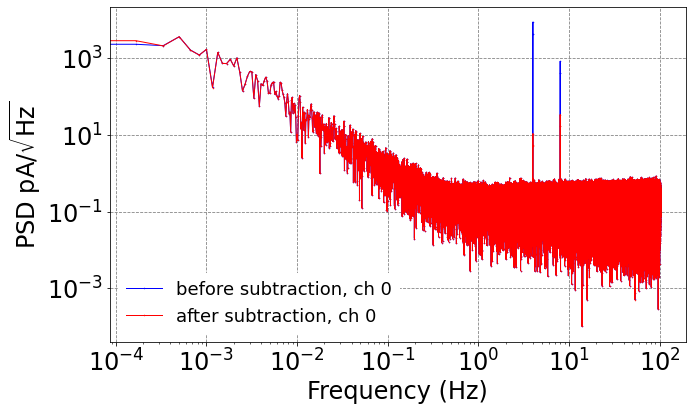

In [154]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

for i in [0]:
    psd_b = np.sqrt(np.abs(ffts_b[i])**2/norm_fact)
    plt.loglog(freqs_b, psd_b, '.-', markersize=1, color='b',lw=1, label='before subtraction, ch ' + str(i))
for i in [0]:
    psd_a = np.sqrt(np.abs(ffts_a[i])**2/norm_fact)
    plt.loglog(freqs_a, psd_a, '.-', markersize=1, color='r',lw=1, label='after subtraction, ch ' + str(i))
plt.legend()
plt.show()

# Demodulation of Simulated TODs

In [81]:
hwp.demod(aman,bpf_width=0.1,lpf_cut=1,signal='signal_hwpss')

In [84]:
ffts_b, freqs_b = rfft(aman, resize=None, signal_name='signal_sub_hwpss')
ffts_a, freqs_a = rfft(aman, resize=None, signal_name='signal_demod')
tsamp = np.median(np.diff(aman_sim.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman_sim.samps.count))**2)
mask_lpf = np.where(freqs_a<1)

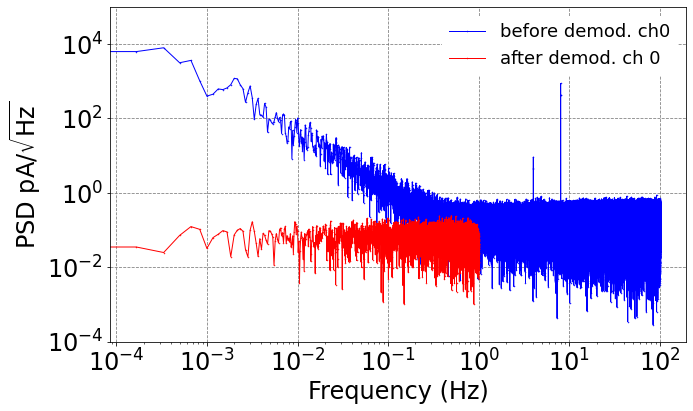

In [87]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')
for i in [0]:
    psd_b = np.sqrt(np.abs(ffts_b[i])**2/norm_fact)
    plt.loglog(freqs_b, psd_b, '.-', markersize=1, color='b',lw=1, label='before demod. ch' + str(i))
for i in [0]:
    psd_a = np.sqrt(np.abs(ffts_a[i])**2/norm_fact)
    plt.loglog(freqs_a[mask_lpf], psd_a[mask_lpf], '.-', markersize=1, color='r',lw=1, label='after demod. ch ' + str(i))
plt.legend()
plt.ylim(1e-4,1e5)
plt.show()

# HWP Analysis using TSAT data

In [191]:
import scipy
hwp_angle = scipy.interpolate.interp1d(solved_rot['fast_time'], solved_rot['angle'], kind='linear',fill_value='extrapolate')(aman.timestamps) % (2*np.pi)

## HWPSS

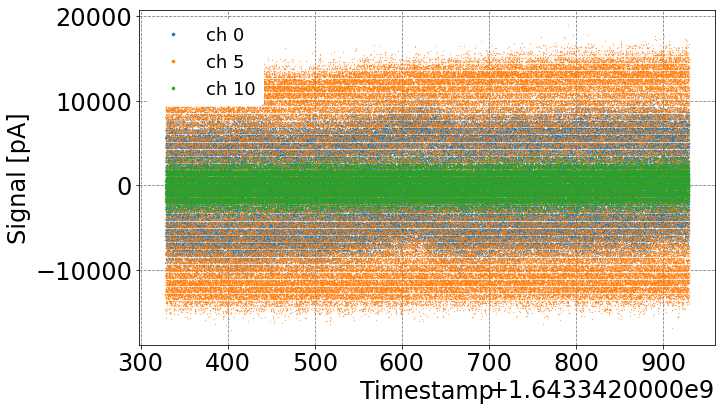

In [192]:
plt.figure(figsize=(10,6))
plt.xlabel('Timestamp')
plt.ylabel('Signal [pA]')
for i in [0,5,10]:
    plt.plot(aman.timestamps,aman.signal[i] - aman.signal[i].mean(),".", markersize=0.5, label='ch ' + str(i))
plt.legend(markerscale=10)
plt.show()

In [196]:
filt = tod_ops.filters.high_pass_sine2(cutoff=0.01)
aman.signal_prefilt = tod_ops.fourier_filter(aman, filt, detrend=None, signal_name='signal')

In [198]:
bins=361
hwpss_denom = np.histogram(hwp_angle, bins=bins, range=[0, 2*np.pi])[0]
hwp_angle_bins = np.linspace(0,2*np.pi,bins)
hwpss=[]
for i in range(aman.dets.count):
    hwpss.append(np.histogram(hwp_angle, bins=bins, range=[0, 2*np.pi], weights=aman.signal_prefilt[i])[0] / np.where(hwpss_denom==0, 1, hwpss_denom))
    idx = np.argwhere(hwpss[i]!=0).flatten()
    if i == 0: hwp_angle_bins = hwp_angle_bins[idx]
    hwpss[i] = hwpss[i][idx]

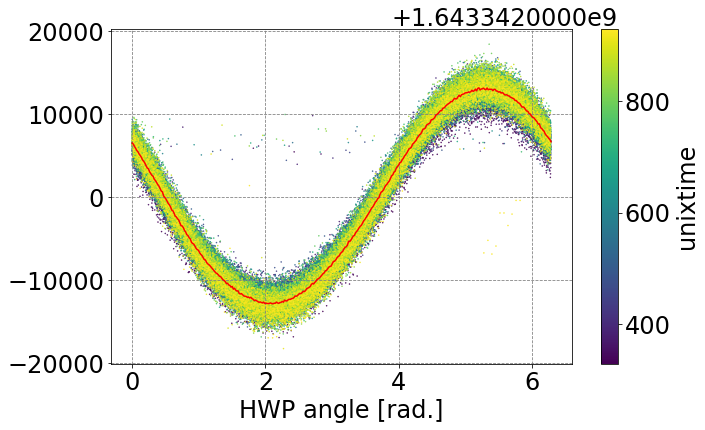

In [202]:
plt.figure(figsize=(10,6))
#plt.ylabel('TOD [pW]')
plt.xlabel('HWP angle [rad.]')
mappable=plt.scatter(hwp_angle, aman.signal_prefilt[5], c=aman.timestamps, marker='.', s=1)
plt.plot(hwp_angle_bins,hwpss[5],"r-")
plt.rcParams['axes.grid'] = False
cbar = plt.colorbar()
cbar.set_label('unixtime')
plt.rcParams['axes.grid'] = True
plt.show()

In [203]:
ffts, freqs = rfft(aman, resize=None)
tsamp = np.median(np.diff(aman.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman.samps.count))**2)

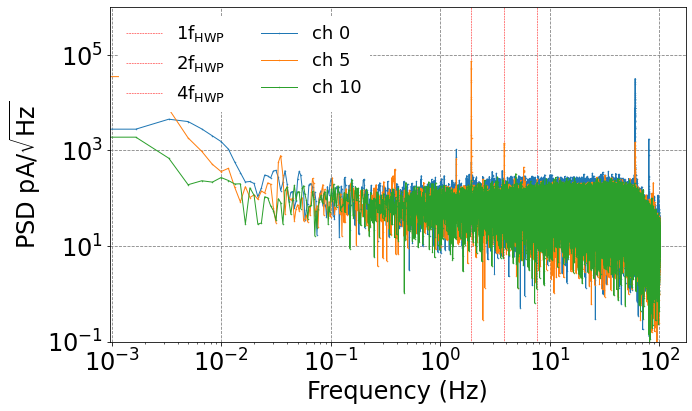

In [204]:
plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

fhwp = hwp_rate.mean()
plt.vlines(1*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'1f$_{\mathrm{HWP}}$')
plt.vlines(2*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'2f$_{\mathrm{HWP}}$')
plt.vlines(4*fhwp,0,1e11,color='r',lw=0.5,linestyle='--',label=r'4f$_{\mathrm{HWP}}$')

#for i in range(aman.dets.count):
for i in [0,5,10]:
    psd = np.sqrt(np.abs(ffts[i])**2/norm_fact)
    plt.loglog(freqs, psd, '.-', markersize=1, lw=1, label='ch ' + str(i))
plt.ylim(1e-1,1e6)
plt.legend(loc=2,ncol=2)
plt.show()

## Demodulation 

In [222]:
hwp.demod(aman,hwp_angle)

In [223]:
ffts, freqs = rfft(aman, resize=None, signal_name='signal')
ffts_demod, freqs_demod = rfft(aman, resize=None, signal_name='signal_demod')
tsamp = np.median(np.diff(aman.timestamps))
norm_fact =  np.sqrt(2)*(1.0/tsamp)*np.sum(np.abs(np.hanning(aman.samps.count))**2)
mask_lpf = np.where(freqs<0.5)

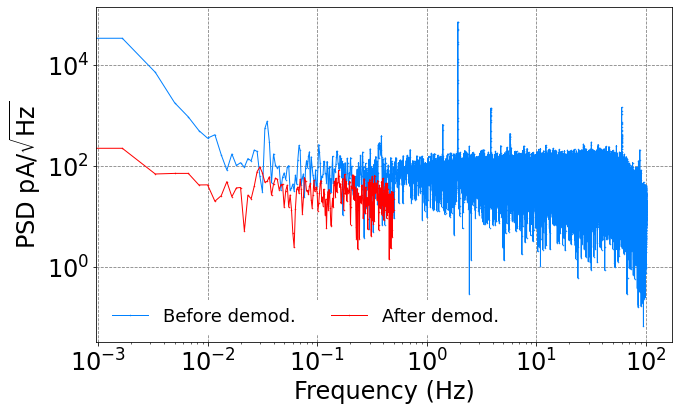

In [226]:
fig = plt.figure(figsize=(10,6))
plt.ylabel('PSD $\mathrm{pA / \sqrt{Hz}}$')
plt.xlabel('Frequency (Hz)')

for i in [5]:
    psd = np.sqrt(np.abs(ffts[i])**2/norm_fact)
    plt.loglog(freqs, psd, '.-', markersize=1, color=cm.jet(i/20),lw=1, label='Before demod.')
    psd_demod = np.sqrt(np.abs(ffts_demod[i])**2/norm_fact)
    plt.loglog(freqs_demod[mask_lpf], psd_demod[mask_lpf], '.-', markersize=1, color='r' ,lw=1, label='After demod.')

plt.legend(ncol=2,fontsize=18)
plt.show()

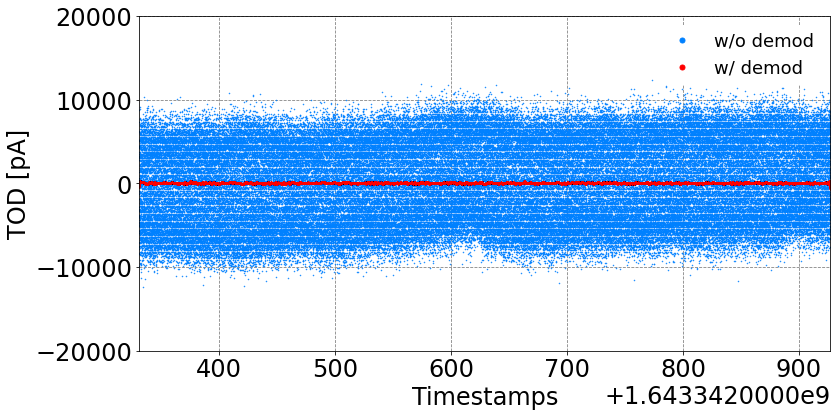

In [232]:
fig = plt.figure(figsize=(12,6))
plt.ylabel('TOD [pA]')
plt.xlabel('Timestamps')
mask = np.zeros_like(aman.timestamps, np.bool_)
mask[:] = 1
plt.plot(aman.timestamps[mask], aman.signal[0][mask] - aman.signal[0][mask].mean(),  '.', color=cm.jet(5/20), label='w/o demod', markersize=1)
plt.plot(aman.timestamps[mask], aman.signal_demod[0][mask] - aman.signal_demod[0][mask].mean(),  '.r', label='w/ demod', markersize=1)
plt.legend(markerscale=10)
plt.xlim(aman.timestamps[500],aman.timestamps[-500])
plt.ylim(-20000,20000)
plt.show()